<a href="https://colab.research.google.com/github/AlejandroVillazonG/Tareas_INF398/blob/main/T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>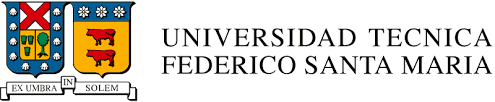</center>



<hr style="height:2px;border:none"/>
<h1 align='center'> INF-398 INTRODUCCIÓN AL APRENDIZAJE AUTOMÁTICO - 2023-1 </h1>

<H3 align='center'> Tarea 2  </H3>
<hr style="height:2px;border:none"/>

<H3 align='center'> Joaquín Aguirre - Alejandro Villazón  </H3>
<hr style="height:2px;border:none"/>

**Temas**
* Manipulaciones en pandas y numpy, imputación de datos y preprocesamientos
* Feature Engineering
* Regresión
* Clasificación
* Árboles y Bosques de Regresión
* Máquinas de ensamblado
* Redes Neuronales

Importe las librerías necesarias para cargar explorar el conjunto de datos.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, mean_squared_error, classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

import os
from urllib import request
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings

# Ignorar las advertencias
warnings.filterwarnings("ignore")

El siguiente código nos facilita la descarga de los archivos para ambas preguntas.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alejandrovillazon","key":"ec3be0ada702ca938581b0dd2cbe5e33"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 1. Predicción de la calidad de vinos

Los árboles de regresión, también conocidos como árboles de decisión para regresión, son un tipo de algoritmo de aprendizaje supervisado que se utiliza para predecir valores numéricos. Son una potente herramienta para tareas de regresión y ofrecen varias ventajas y consideraciones.

<center><img src=https://cdn.shopify.com/s/files/1/1277/3667/files/an-essential-guide-1_480x480.png?v=1674719515></center>


Los conjuntos de datos provienen del UCI Machine Learning Repository. Estos conjuntos de datos están relacionados con las variantes tintas y blancas del vino portugués "Vinho Verde".

Estos dos conjuntos de datos contienen varias propiedades químicas de distintos vinos, como la acidez, el pH, el contenido de alcohol, etc. La variable objetivo es la calidad del vino la cual se puntúa del 0 al 10. Puede considerarse una tarea de clasificación o regresión en la que las clases están ordenadas y no balanceadas. Para esta pregunta nos centraremos en la tarea de regresión.

Variables de entrada (basadas en pruebas físico-químicas):
* fixed acidity
* volatile acidity
* citric acid
* residual sugar
* chlorides
* free sulfur dioxide
* total sulfur dioxide
* density
* pH
* sulphates
* alcohol
* tipo

Variable objetivo (basadas en datos sensoriales):
* quality



Para obtener más información sobre este conjunto de datos, revise el siguiente link: https://www.kaggle.com/datasets/rajyellow46/wine-quality.

## 1.1 Manipulación y exploración del conjunto de datos

Lo primero es obtener los datos, para esto se pueden descargar los archivos directamente de la página de Kaggle a través del link de la descripción de arriba.

Aplique lo aprendido en la tarea 1 y obtenga los datos de la forma que le sea más conveniente siempre y cuando estos sean los del link de la descripción.

In [ ]:
!kaggle datasets download -d rajyellow46/wine-quality > /dev/null

!unzip /content/wine-quality.zip > /dev/null

100% 98.0k/98.0k [00:00<00:00, 62.7MB/s]


In [ ]:
df = pd.read_csv('/content/winequalityN.csv')

### 1.1.1 Exploración del conjunto de datos

Explore el conjunto de datos y responda brevemente las siguientes preguntas:

> a) ¿Cuáles variables poseen valores numéricos y cuáles poseen valores categóricos?

In [ ]:
def datainfo(data):
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100
    return temp_ps

df_info = datainfo(df)

In [ ]:
df_info.DataType

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Name: DataType, dtype: object

Desde la fuente sin ninguna modificación, tenemos que todas las variables a excepción de _type_ son del tipo numérica, y la variable _type_ es del tipo categórica. Tambien notamos que de las variables del tipo numérica, la única variable que toma valores enteros es _quality_, que podriamos entender como tipo categórica según la información que tenemos del conjunto de datos, pero al menos desde la fuente es numérica.

> b) ¿Existen datos faltantes, si es así en qué atributos faltan datos y cuantos faltan?

Si existen datos faltantes en el conjunto de datos, los atributos que los presentan se muestran a continuación, junto a la cantidad de datos faltantes:

In [ ]:
df_info.query('NaN_Values > 0').NaN_Values

fixed acidity       10
volatile acidity     8
citric acid          3
residual sugar       2
chlorides            2
pH                   9
sulphates            4
Name: NaN_Values, dtype: int64

> c) ¿Qué técnicas conoce para rellenar los datos faltantes de los atributos del dataset? (si no conoce ninguna investigue al menos 2)

Conocemos las siguientes técnicas:

* Rellenar los datos faltantes con el promedio o mediana del atributo en cuestión, tenemos como opción antes agrupar los datos según otro atributo (por ejemplo la variable target) y luego aplicar esta técnica.

* Interpolación en los datos faltantes, consiste en aplicar una interpolación en la columna del atributo en cuestión, esta puede ser por ejemplo una interpolación lineal. Se recomienda/usa cuando los datos son temporales, por ejemplo con series económicas se utiliza esta técnica al cambiar la frecuencia de los datos, por ejemplo de trimestral a mensual, se rellenan los datos de los meses intermedios interpolando.

### 1.1.2 Exploración de Features

En problemas de regresión, el desbalance de la variable objetivo se refiere a una distribución desigual de los valores de la variable objetivo en el conjunto de datos. Esto significa que hay una presencia significativa de valores en una clase o rango de valores en comparación con otras clases o rangos de valores. Considerando lo anterior responda las siguientes preguntas:

> a) Grafique histogramas y box plots de cada variable y comente acerca de la distribución de las características y de la variable objetivo

Grafiquemos primero los histogramas:



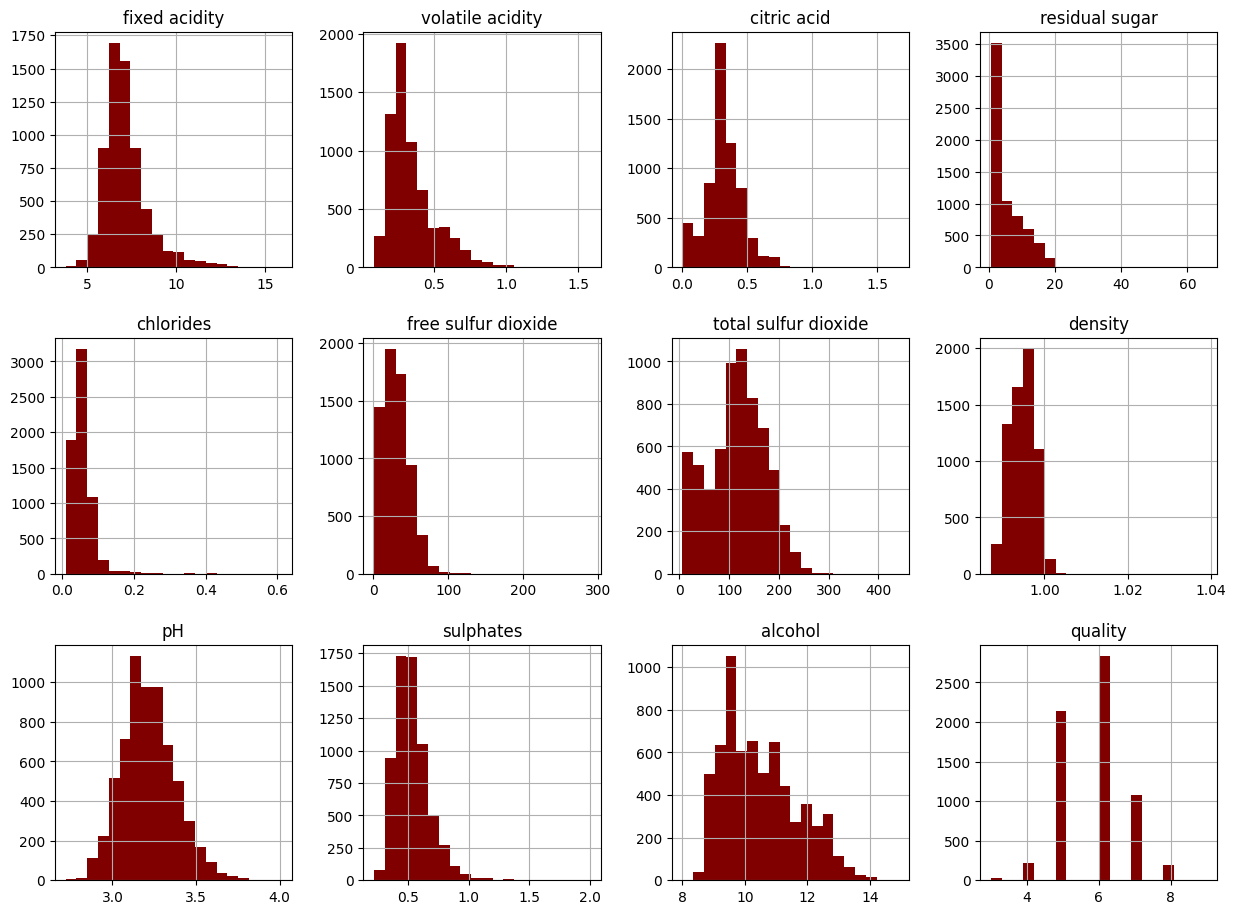

In [ ]:
df.hist(figsize=(15,15), layout=(4,4), bins=20, color = 'maroon');

Para complementar los histogramas notemos algunas estadísticas básicas relacionadas a las variables.

In [ ]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Viendo la relación entre el mínimo y máximo de algunas variables como 'residual sugar' o 'clhorides' podemos explicar porque en el eje x el histograma de algunas variables presentan espacios que a simple vista aparecen blancos.

Antes de realizar los comentarios de forma general, grafiquemos los boxplots:

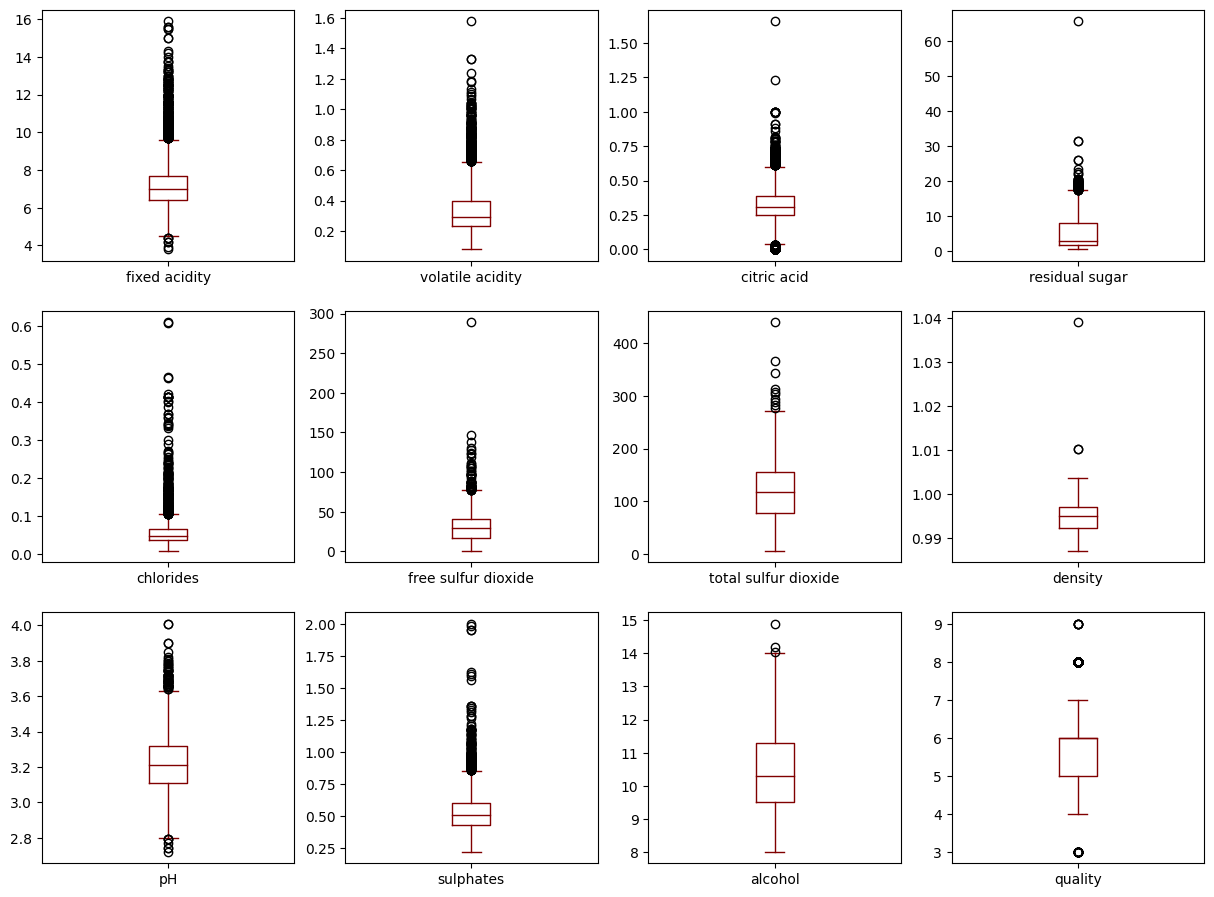

In [ ]:
df.plot(kind="box",
        subplots=True,
        layout=(4,4),
        figsize=(15,15),
        color = 'maroon');

Primero podemos notar de los boxplots que todas las variables presentan outliers.

De ambas gráficas podemos comentar los siguientes puntos:
- La variable "quality" tiene la mayoría de sus valores concentrados en las categorías 5, 6 y 7. Solo una pequeña proporción se encuentra en las categorías [3, 4] y [8, 9], y ninguna en las categorías [1, 2] y 10.

- Si se eliminan los outliers de las variables "fixed acidity", "volatile acidity" y "citric acid" la distribución de las variables puede considerarse simétrica viendo su histograma.

- La variable "residual sugar" tiene una distribución sesgada al cero, incluso después de eliminar los valores atípicos, la distribución seguirá sesgada.

- Algunas variables, como "free sulphur dioxide" y "density", tienen
unos pocos valores atípicos, pero estos son muy diferentes al resto.

- En su mayoría, los valores atípicos están en el extremo superior.

- La variable "alcohol" tiene una distribución de forma irregular, pero no tiene valores atípicos pronunciados.

- De todas las variables, "pH" presenta una distribución muy parecida a una normal.



> b) ¿Considera que están *balanceados* los valores de la variable objetivo?

Al ver el porcentaje de los valores, nos podemos dar cuenta que la gran masa de los observaciones tiene calidad 5, 6 o 7, en cambio las otras clases aparecen con poca frecuencia, por lo que claramente no están balanceados.

In [ ]:
df["quality"].value_counts(normalize = True)*100

6    43.650916
5    32.907496
7    16.607665
4     3.324611
8     2.970602
3     0.461752
9     0.076959
Name: quality, dtype: float64

> c) ¿Cómo afecta el desbalance en problemas de regresión en términos de la predicción y de la evaluación de un modelo?

En términos de la predicción, cuando existe un desbalance en los valores de la variable objetivo, el modelo puede verse sesgado hacia la mayoría de los valores dominantes. Esto significa que el modelo puede tener dificultades para capturar y predecir con precisión los valores de la clase minoritaria o los valores menos representados en los datos. Como resultado, el modelo puede tener una tendencia a predecir con mayor precisión los valores de la clase mayoritaria, mientras que los valores de la clase minoritaria pueden estar subrepresentados o subestimados, lo cual afecta en términos de la evaluación del modelo.

Binarizamos la variable _type_:

In [ ]:
df = pd.get_dummies(df,drop_first=True)

### 1.1.3 Separación de conjuntos

> a) Separe el conjunto entre variables características y variable objetivo.

In [ ]:
X = df.drop(['quality'], axis = 1)
y = df['quality']


> b) Separe el conjunto de datos en un conjunto de entrenamiento y conjunto de prueba, utilizando una proporción 80%-20% respectivamente.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 42)

> c) Una vez separado los conjuntos, obtenga la media de cada variable con datos faltantes en el conjunto de **entrenamiento** y reemplace los valores faltantes (NaN) de ambos conjuntos (entrenamiento y prueba) con dicha media.

In [ ]:
for column in X_train.columns[X_train.isnull().sum()>0]:
  # Primero rellenamos X_test, pues si primero lo hacemos en X_train
  # cambiará el valor del promedio.
  X_test[column] = X_test[column].fillna(X_train[column].mean())
  X_train[column] = X_train[column].fillna(X_train[column].mean())
  print(f"Se rellenó la variable: {column}")

Se rellenó la variable: fixed acidity
Se rellenó la variable: volatile acidity
Se rellenó la variable: citric acid
Se rellenó la variable: residual sugar
Se rellenó la variable: chlorides
Se rellenó la variable: pH
Se rellenó la variable: sulphates


> d) Estandarice las variables categóricas numéricas no binarias, es decir, todas excepto el tipo de vino y la variable objetivo.

In [ ]:
X_scaler = StandardScaler()

X_train[X_train.columns.drop('type_white')] = X_scaler.fit_transform(X_train[X_train.columns.drop('type_white')])

X_test[X_test.columns.drop('type_white')] = X_scaler.transform(X_test[X_test.columns.drop('type_white')])

e) Grafique la relevancia de cada variable con respecto a la variable objetivo utilizando la información mutua entre ambas, en otras palabras: MutualInformation($x_i,y$) siendo $x_i$ la $i$-ésima variable.

In [ ]:
mutual_info_classif(X_train, y_train, random_state = 42)

array([0.01961884, 0.06042501, 0.03050506, 0.06431787, 0.07397796,
       0.03882861, 0.07218654, 0.14995477, 0.023854  , 0.03908876,
       0.16364905, 0.0084562 ])

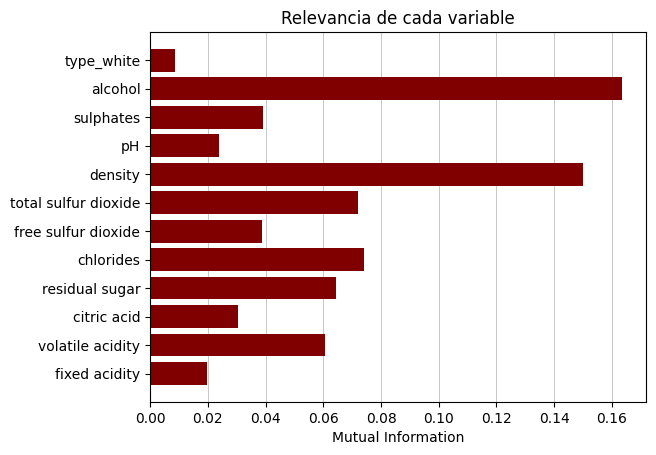

In [ ]:
mi = mutual_info_classif(X_train, y_train, random_state = 42)

plt.barh(y = X_train.columns,
         width = mi,
         zorder = 2,
         color = 'maroon'
        )
plt.xlabel('Mutual Information')
plt.grid(axis = 'x', linewidth=0.5)
plt.title('Relevancia de cada variable')
plt.show()

Del gráfico anterior, notamos que según la información mutua, las variables más relevantes son: _alcohol_ y _density_.

> f) Cree un segundo conjunto quitando las características que menos aportan información según lo observado en su gráfico de la pregunta anterior. El número de características a quitar es algo que usted deberá escoger y argumentar por qué lo escogió. En adelante al conjunto con todas las variables lo llamaremos conjunto $\textit{A}$ y al nuevo conjunto creado con las características quitadas lo llamaremos conjunto $\textit{B}$.

Elegiremos las variables que tienen información mutua mayor o igual al promedio de estas, esto debido a la distribución observada en el gráfico, al elegir el promedio como umbral establecemos un punto medio entre el aporte de las variables, considerando también aquellas que tienen un aporte moderado.

A continuación, se muestran las variables que tienen una información mutua mayor o igual al promedio,

In [ ]:
print(*X_train.columns[mi >= mi.mean()], sep = '\n')

residual sugar
chlorides
total sulfur dioxide
density
alcohol


Por lo tanto, nos quedaremos con las cinco características anteriores en el conjunto B:

In [ ]:
X_train_B = X_train.drop(X_train.columns[mi < mi.mean()], axis = 1)
X_test_B = X_test.drop(X_train.columns[mi < mi.mean()], axis = 1)

## 1.2 Modelos de Regresión


Para las siguientes preguntas usted debera entrenar, validar y evaluar los modelos utilizando los conjuntos $A$ y $B$ por separado, para luego hacer las respectivas comparaciones entre ambos. Cada modelo tiene sus propios hiperparámetros que usted deberá ajustar a través de una búsqueda en grilla, obteniendo así un conjunto de modelos distintos para posteriormente comparar las métricas de evaluación sobre el conjunto de prueba. Usted estará explorando un subconjunto del espacio de hipótesis variando los hiperparámetros que se le indiquen en cada modelo usando el módulo gridsearchcv de la librería sklearn. En el módulo gridsearchcv fije fije los parámetros de la forma:



```
GridSearchCV(estimator, param_grid, scoring=mean_squared_error, refit=True)
```

Siendo estimator el modelo a utilizar, scoring, la métrica para evaluar el modelo y refit=True para una vez probado todo el subconjunto del espacio de hipótesis, escojer el mejor modelo y entrenarlo con todo el conjunto de entrenamiento.

### 1.2.1 Árbol de regresión


Entrene un árbol de regresión manteniendo fijos por defecto los que no se mencionen y variando los siguientes parámetros utilizando el módulo gridsearchcv de la librería sklearn:

> a) max_depth: Probar con las profundidades 2, 20, 200. Describa brevemente qué es lo que significa modificar este hiperparámetro.

El hiperparámetro _max_depth_ especifica la profundidad máxima permitida en el árbol. Por lo tanto, modificar este hiperparámetro implica cambiar el número máximo de divisiones o niveles que el árbol puede tener desde la raíz hasta las hojas. A mayor _max_depth_, mayor complejidad tendrá el modelo.

> b) max_leaf_nodes: Probar con los valores 10, 50, 100. Describa brevemente qué es lo que significa modificar este hiperparámetro.

El hiperparámetro _max_leaf_nodes_ define el número máximo de nodos hoja permitidos en el árbol. Por lo tanto, modificar este hiperparámetro significa variar el número máximo de nodos terminales que no se dividen más dentro del árbol. A mayor _max_leaf_nodes_, mayor complejidad tendrá el modelo.

Para mejorar el ajuste del modelo de regresión estandarizaremos la variable target.

In [ ]:
y_scaler = StandardScaler()

y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1,1))

In [ ]:
tree_model_A = DecisionTreeRegressor(random_state = 42)
tree_model_B = DecisionTreeRegressor(random_state = 42)

param_grid = {
    'max_depth': [2, 20, 200],
    'max_leaf_nodes': [10, 50, 100]
}

grid_search_A = GridSearchCV(estimator=tree_model_A,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             refit=True)

grid_search_B = GridSearchCV(estimator=tree_model_B,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             refit=True)
grid_search_A.fit(X_train, y_train)
grid_search_B.fit(X_train_B, y_train);

Responda las siguientes preguntas:

> c) ¿Cuántos modelos de árboles de regresión le quedan en total?

Se obtienen 9 modelos por cada representación A y B, se obtienen 9 pues esa es la cantidad de combinaciones que obtenemos al variar los dos hiperparámetros con 3 valores posibles cada uno, a continuación se presentan las 9 combinaciones mencionadas para ambas representaciones:

In [ ]:
print(*grid_search_A.cv_results_['params'], sep='\n')

{'max_depth': 2, 'max_leaf_nodes': 10}
{'max_depth': 2, 'max_leaf_nodes': 50}
{'max_depth': 2, 'max_leaf_nodes': 100}
{'max_depth': 20, 'max_leaf_nodes': 10}
{'max_depth': 20, 'max_leaf_nodes': 50}
{'max_depth': 20, 'max_leaf_nodes': 100}
{'max_depth': 200, 'max_leaf_nodes': 10}
{'max_depth': 200, 'max_leaf_nodes': 50}
{'max_depth': 200, 'max_leaf_nodes': 100}


> d) De todas las combinaciones que entrenó, ¿cual es la que mejores resultados le da? Para esta pregunta evalue el modelo con el conjunto de validación de la grilla utilizando la métrica de evaluación $mean\_squared\_error$.

La mejor combinación de hiperparámetros para cada representación son las que siguen:

In [ ]:
print('Para la representación A:',*[f"{key} = {value}" for key, value in grid_search_A.best_params_.items()], sep = "\n\t")
print('\nPara la representación B:',*[f"{key} = {value}" for key, value in grid_search_B.best_params_.items()], sep = "\n\t")

Para la representación A:
	max_depth = 20
	max_leaf_nodes = 50

Para la representación B:
	max_depth = 20
	max_leaf_nodes = 10


Luego, si comparamos los resultados del MSE en el conjunto de validación para cada representación tenemos que el mejor modelo se da para la representación A:

In [ ]:
grid_search_A.cv_results_['mean_test_score'].max() > grid_search_B.cv_results_['mean_test_score'].max()

True

Por lo tanto, basados en la métrica MSE para el conjunto de validación de la grilla, el mejor modelo es utilizando la representación A, con _max_depth_ = 20 y _max_leaf_nodes_ = 50.

> c) Entrene el conjunto de entrenamiento completo con el mejor modelo y mejor representación ($A$ o $B$) obtenida y evalúe su desempeño sobre el conjunto de prueba utilizando la métrica de evaluación $mean\_squared\_error$.

Basados en los resultados anteriores definimos el mejor modelo a continuación:

In [ ]:
model_DT = DecisionTreeRegressor(max_depth = 20,
                                 max_leaf_nodes = 50,
                                 random_state = 42)
model_DT.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=20, max_leaf_nodes=50, random_state=42)

In [ ]:
mse_model_DT = mean_squared_error(y_test, y_scaler.inverse_transform(np.array(model_DT.predict(X_test)).reshape(-1,1)))
print(mse_model_DT)

0.47483543211390333


Dadas las unidades del target (entre 0 y 10) podemos decir que es un orden de magnitud menor, por lo que podemos concluir que el error es pequeño.

### 1.2.2 Random Forest Regressor

Entrene un bosque aleatorio de regresión manteniendo fijos por defecto los que no se mencionen y variando los siguientes parámetros utilizando el módulo gridsearchcv de la librería sklearn:

* max_depth: Probar con las profundidades 2, 20, 200. Describa brevemente qué es lo que significa modificar este hiperparámetro.

**RESPUESTA:** El hiperparámetro _max_depth_ controla la profundidad máxima que puede tener un árbol de decisión en el bosque aleatorio.

* max_samples: Probar con las siguientes proporciones 0.1, 0.5, 1.0. Describa brevemente qué es lo que significa modificar este hiperparámetro.


**RESPUESTA:** Este hiperparámetro determina la proporción de muestras de entrenamiento que se utilizarán para construir cada árbol individual dentro del bosque aleatorio.

In [ ]:
rfg_A = RandomForestRegressor(random_state = 42)
rfg_B = RandomForestRegressor(random_state = 42)

param_grid = {
    'max_depth': [2, 20, 200],
    'max_samples': [0.1, 0.5, 1.0]
}

grid_search_A = GridSearchCV(estimator=rfg_A,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             refit=True)
grid_search_B = GridSearchCV(estimator=rfg_B,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             refit=True)

grid_search_A.fit(X_train, y_train)
grid_search_B.fit(X_train_B, y_train);


El objetivo de los métodos $\textit{ensemble machine}$ es combinar las predicciones de varios estimadores base construidos con un algoritmo de aprendizaje determinado para mejorar la capacidad de generalización / robustez respecto a un único estimador. Se suelen distinguir dos familias de métodos ensemble: los métodos $averaging$ y los métodos $boosting$. Respecto a lo anterior responda las siguientes preguntas:

> a) Defina con sus propias palabras qué son y en qué se diferencian los métodos $averaging$ y $boosting$.

Son métodos que combinan distintos modelos para mejorar la generalización y robustez del modelo final. Se diferencian en la forma en que se combinan los modelos base, los métodos _averaging_ promedian las predicciones de los estimadores base de forma independiente, mientras que los métodos _boosting_ combinan los estimadores secuencialmente, enfocándose en corregir los errores de los modelos anteriores.

> b) A cual de los dos anteriormente definidos pertenece el modelo de regresión Random Forest?

Pertenece al método _averaging_, pues promedia las predicciones de distintos modelos tipo árbol de decisión para entregar el resultado final.

> c) De todas las combinaciones que entrenó, ¿cual es la que mejores resultados le da? Para esta pregunta evalue el modelo con el conjunto de validación utilizando la métrica de evaluación $mean\_squared\_error$.

A continuación, se presentan las mejores combinaciones de hiperparámetros encontradas para cada representación,

In [ ]:
print('Para la representación A:',*[f"{key} = {value}" for key, value in grid_search_A.best_params_.items()], sep = "\n\t")
print('\nPara la representación B:',*[f"{key} = {value}" for key, value in grid_search_B.best_params_.items()], sep = "\n\t")

Para la representación A:
	max_depth = 200
	max_samples = 1.0

Para la representación B:
	max_depth = 200
	max_samples = 1.0


Comparemos las representaciones basados en el MSE del conjunto de validación de la grilla:

In [ ]:
grid_search_A.cv_results_['mean_test_score'].max() > grid_search_B.cv_results_['mean_test_score'].max()

True

Por lo tanto, basados en la métrica MSE, el mejor modelo es utilizando la representación A, con _max_depth_ = 200 y _max_samples_ = 1.

Ajustemos y obtengamos el MSE en el conjunto de test utilizando el mejor modelo encontrado:

In [ ]:
model_RF = RandomForestRegressor(max_depth = 200, max_samples = 1.0, random_state = 42)
model_RF.fit(X_train, y_train)
mse_model_RF = mean_squared_error(y_test, y_scaler.inverse_transform(np.array(model_RF.predict(X_test)).reshape(-1,1)))
print(mse_model_RF)

0.31653346153846157


### 1.2.3 Bagging Regressor


Entrene un Bagging regresor utilizando como estimador (parámetro $estimator$) el mejor árbol de decisión obtenido en la pregunta 1.2.1, variando los siguientes parámetros utilizando el módulo gridsearchcv de la librería sklearn:

* n_estimators: Probar con 10, 100, 1000 estimadores. Describa brevemente qué es lo que significa modificar este hiperparámetro.


**RESPUESTA:** Modificar este hiperparámetro controla el número de estimadores base que se utilizan en el conjunto.

* max_samples: Probar con las siguientes proporciones 0.1, 0.5, 1.0. Describa brevemente qué es lo que significa modificar este hiperparámetro.


**RESPUESTA:** Modificar el hiperparámetro _max_samples_ controla la proporción de muestras utilizadas para entrenar cada estimador base en el conjunto.

In [ ]:
bagging_A = BaggingRegressor(estimator=model_DT, random_state = 42)
bagging_B = BaggingRegressor(estimator=model_DT, random_state = 42)

param_grid = {
    'n_estimators': [10, 100, 1000],
    'max_samples': [0.1, 0.5, 1.0]
}

grid_search_A = GridSearchCV(estimator=bagging_A,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             refit=True)
grid_search_B = GridSearchCV(estimator=bagging_B,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             refit=True)

grid_search_A.fit(X_train, y_train)
grid_search_B.fit(X_train_B, y_train);

Responda las siguientes preguntas

> a) ¿Cómo funciona el modelo Bagging?

El modelo Bagging funciona mediante la creación de múltiples subconjuntos de datos a través de muestreo con reemplazo (bootstrap), donde se entrena un estimador base independiente en cada subconjunto. Luego, las predicciones de los estimadores base se promedian para obtener la predicción final del modelo Bagging.

> b) A qué familia de métodos pertenece el Bagging regresor: $averaging$ o $boosting$.

Pertenece a la familia _averaging_.

> c) De todas las combinaciones que entrenó, ¿cual es la que mejores resultados le da? Para esta pregunta evalue el modelo con el conjunto de validación utilizando la métrica de evaluación $mean\_squared\_error$.

In [ ]:
print('Para la representación A:',*[f"{key} = {value}" for key, value in grid_search_A.best_params_.items()], sep = "\n\t")
print('\nPara la representación B:',*[f"{key} = {value}" for key, value in grid_search_B.best_params_.items()], sep = "\n\t")

Para la representación A:
	max_samples = 0.5
	n_estimators = 1000

Para la representación B:
	max_samples = 0.5
	n_estimators = 100


Comparemos las representaciones A y B según el MSE del conjunto de validación:

In [ ]:
grid_search_A.cv_results_['mean_test_score'].max() > grid_search_B.cv_results_['mean_test_score'].max()

True

Por lo tanto, basados en la métrica MSE, el mejor modelo es utilizando la representación A, con _max_samples_ = 0.5 y *n_estimators* = 1000.

Ajustemos y obtengamos el MSE en el conjunto de test utilizando el mejor modelo encontrado:

In [ ]:
model_BR = BaggingRegressor(estimator = model_DT,
                            max_samples = 0.5,
                            n_estimators = 1000,
                            random_state = 42)
model_BR.fit(X_train,y_train)
mse_model_BR = mean_squared_error(y_test, y_scaler.inverse_transform(np.array(model_BR.predict(X_test)).reshape(-1, 1)))
print(mse_model_BR)

0.4163830224359799


## 1.3 Conclusiones

Comente con qué modelo y representación obtiene los mejores resultados, ¿qué otros experimentos realizaría para intentar mejorar los resultados?

Notamos de los resultados anteriores que para cada modelo la mejor representación es la A, es decir, la que tiene todos los atributos. Comparemos los mejores modelos obtenidos en cada caso:

In [ ]:
mse_model_RF < mse_model_BR < mse_model_DT,  mse_model_RF

(True, 0.31653346153846157)

Dados los valores del MSE en el conjunto de test, podemos notar que el mejor modelo ajustado para nuestro conjunto de datos es el RandomForest con parámetros *max_depth*=200 y *max_samples*=1 y con MSE menor a 0.32, lo cual considerando la escala de la variable target es pequeño.

Siguiendo la misma línea del enfoque de la pregunta, también se pudo haber hecho competir un modelo de tipo boosting, el cual fue el único tipo de ensamblaje en donde no se propuso un modelo.


# 2. Reconocimiento de actividad humana mediante sensores de movimiento.

Los conjuntos de datos provienen del UCI Machine Learning Repository. En este conjuntos de datos cada persona realizó seis actividades (CWALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) llevando un smartphone en la cintura. Utilizando su acelerómetro y giroscopio integrados, capturamos la aceleración lineal de 3 ejes y la velocidad angular de 3 ejes a una frecuencia constante de 50 Hz. El conjunto de datos obtenido se ha dividido aleatoriamente en dos conjuntos, de los que se seleccionó el 70% de los voluntarios para generar los datos de entrenamiento y el 30% los datos de prueba.

<center><img src="https://imgtr.ee/images/2023/06/04/bSx54.jpg" alt="bSx54.jpg" border="0" width="480" height="480" /></center>

Para esta pregunta nos centraremos en la tarea de clasificación de actividades (variable objetivo) según los datos de movimiento proporcionados por los sensores (atributos).

Para cada registro en el conjunto de datos nos centraremos en:
* Aceleración triaxial del acelerómetro (aceleración total) y la aceleración estimada del cuerpo.
* Velocidad angular triaxial del giroscopio.

* Su etiqueta de actividad.

Para obtener el dataset, artículos publicados y más información, por favor dirigirse al siguiente [link](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).



## 2.1 Obtención, manipulación y exploración del conjunto de datos

Con el link proporcionado arriba, haga click en Data Folders y luego en *UCI HAR Dataset.names* para obtener una guía acerca de la estructura de los directorios. Descargue, descomprima los datos y explore la estructura de los directorios (*UCI HAR Dataset.zip*).

Para esta oportunidad solo nos centraremos en los datos que se encuentran en las carpetas *Inertial Signals*, para entrenamiento y pruebas.

Descargaremos el archivo comprimido directamente de la [página web](https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip
):

In [2]:
url = 'https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip'
request.urlretrieve(url, 'human+activity+recognition+using+smartphones.zip');

In [3]:
!unzip /content/human+activity+recognition+using+smartphones.zip > /dev/null

os.rename(r"/content/UCI HAR Dataset.zip", r"/content/UCI_HAR_Dataset.zip")
!unzip /content/UCI_HAR_Dataset.zip > /dev/null

### 2.1.1 Exploración del conjunto de datos

Una vez comprendida la estructura de los directorios, asegurese de poder navegar por los archivos correctamente:

> a) El código a continuación debe imprimir las rutas a todos los archivos del conjunto de datos que usted acaba de descargar. Ejemplo: /su ruta/UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt

In [4]:
for dirname, _, filenames in os.walk('/content/UCI HAR Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/UCI HAR Dataset/.DS_Store
/content/UCI HAR Dataset/features.txt
/content/UCI HAR Dataset/features_info.txt
/content/UCI HAR Dataset/activity_labels.txt
/content/UCI HAR Dataset/README.txt
/content/UCI HAR Dataset/train/subject_train.txt
/content/UCI HAR Dataset/train/y_train.txt
/content/UCI HAR Dataset/train/X_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt
/content/UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt
/content/UCI HAR Dataset/test/subject_tes

In [5]:
LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
SIGNALS = ["body_acc_x_", "body_acc_y_", "body_acc_z_",
           "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
           "total_acc_x_", "total_acc_y_", "total_acc_z_"]

> b) Obtenga la ruta exacta de los archivos e insertelos en una lista (entrenamiento y prueba ). El código a continuación es solo una sugerencia, usted puede optimizar y modificarlo.

In [6]:
train_paths = [f'/content/UCI HAR Dataset/train/Inertial Signals/{signal}train.txt' for signal in SIGNALS]
test_paths = [f'/content/UCI HAR Dataset/test/Inertial Signals/{signal}test.txt' for signal in SIGNALS]

In [7]:
print(*test_paths, sep = '\n')

/content/UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/body_acc_y_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/body_acc_z_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/body_gyro_x_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/body_gyro_y_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/body_gyro_z_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/total_acc_y_test.txt
/content/UCI HAR Dataset/test/Inertial Signals/total_acc_z_test.txt


> c) Cree una función __load_X que reciba una lista de rutas como alguna de las anteriormente creadas, y retorne un arreglo de numpy con las siguientes dimensiones (n_samples, signal_len, sensor) donde:
* n_samples: es el tamaño de la muestra, o sea, el total de experimentos.
* signal_len: es el largo de la señal de los sensores.
* sensor: es el sensor o el eje del sensor el cual registra la señal, por ejemplo acelerómetro en el eje $y$.

In [15]:
def __load_X(X_signal_paths):
  return np.stack([np.loadtxt(path) for path in X_signal_paths], axis = 2)

In [16]:
x_train = __load_X(train_paths)
x_test = __load_X(test_paths)

> d) Cargue las clases del conjunto de entrenamiento y pruebas en arreglos numpy.

In [17]:
y_train = np.loadtxt('/content/UCI HAR Dataset/train/y_train.txt',  dtype=np.int32)
y_test = np.loadtxt('/content/UCI HAR Dataset/test/y_test.txt', dtype=np.int32)

### 2.1.2 Análisis del conjunto de datos

Responda las siguientes preguntas:

> a) ¿Cuántos experimentos le quedan en el conjunto de entrenamiento y en el de test?

In [18]:
print(f'En el conjunto de entrenamiento quedaron: {x_train.shape[0]} experimentos.')
print(f'Mientras que en el conj. de test quedan: {x_test.shape[0]} experimentos.')

En el conjunto de entrenamiento quedaron: 7352 experimentos.
Mientras que en el conj. de test quedan: 2947 experimentos.


> b) ¿Qué valores obtiene para las dimensiones recién definidas (n_samples, signal_len, sensor)?

Obtenemos los siguientes valores:

In [19]:
print(f'Conjunto de entrenamiento: {x_train.shape}')
print(f'Conjunto de prueba: {x_test.shape}')

Conjunto de entrenamiento: (7352, 128, 9)
Conjunto de prueba: (2947, 128, 9)



> c) Considerando todo lo que usted ha aprendido en este curso y en las tareas anteriores, ¿Qué puede decir de los atributos de este conjunto de datos?. Obtenga estadísticas descriptivas y sintetice brevemente con sus propias palabras lo que observe, apoyándose de gráficos como histográmas, boxplots, heatmaps de correlación, etc.

Se decidió escoger como representante el promedio de las señales para cada experimento para obtener un análisis más simple y no bidimensional.

A continuación, se presentan algunos gráficos de interés:

In [20]:
x_train_reduced = np.mean(x_train, axis = 1)

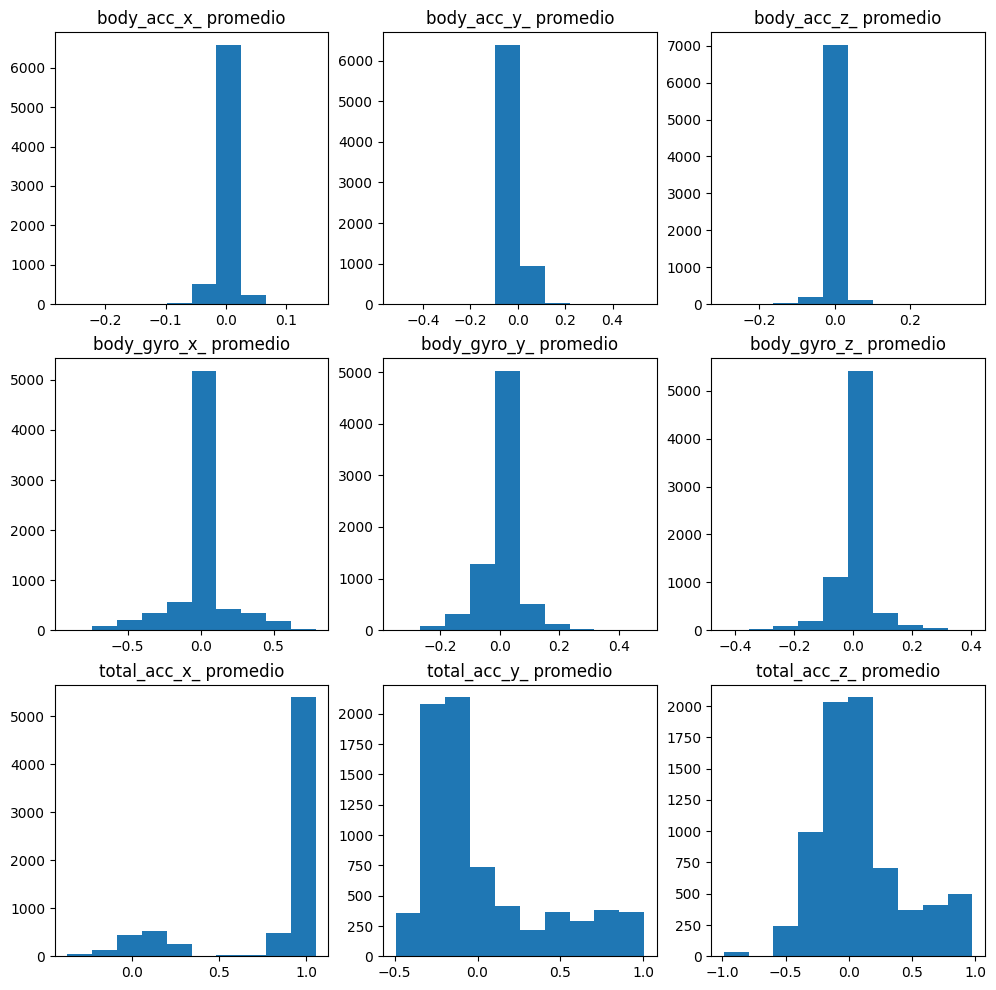

In [21]:
_, axs = plt.subplots(3,3, figsize = (12,12))

for i in range(x_train_reduced.shape[1]):
  axs[i//3,i%3].hist(x_train_reduced[:,i])
  axs[i//3,i%3].set_title(f"{SIGNALS[i]} promedio")

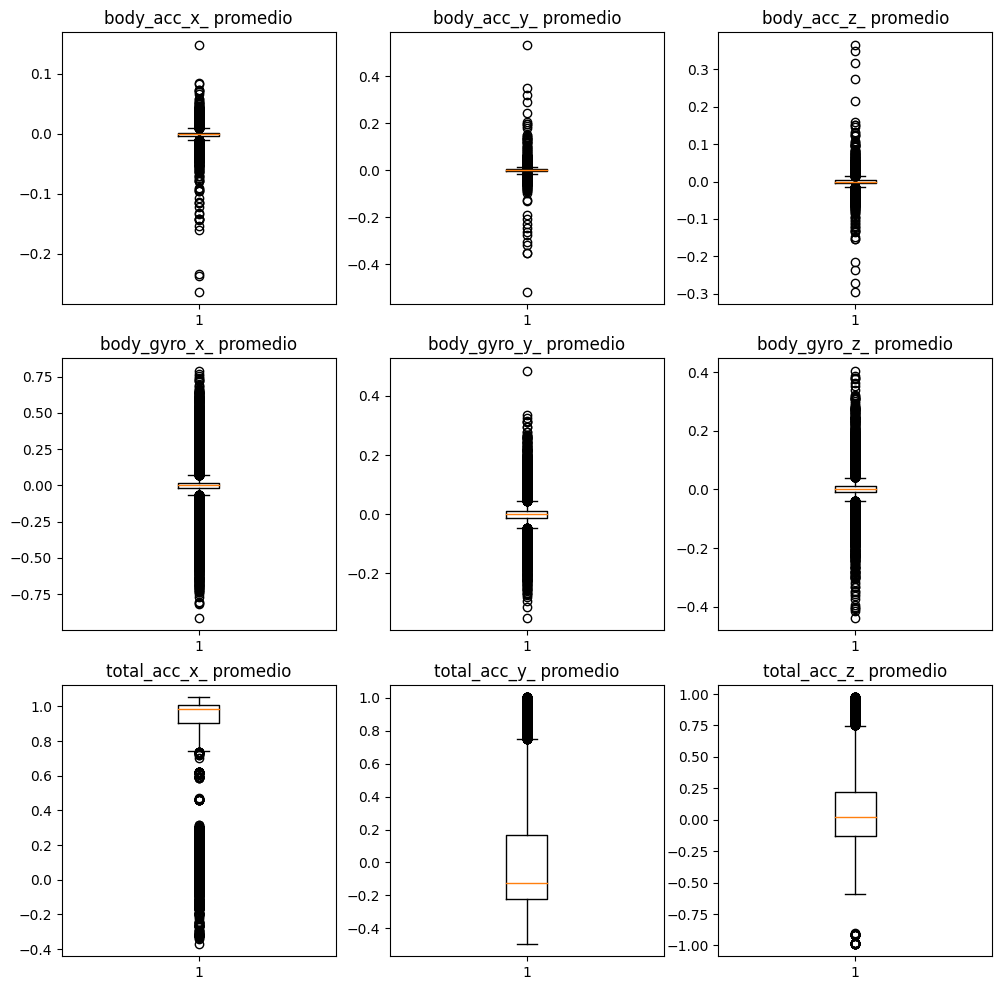

In [22]:
_, axs = plt.subplots(3,3, figsize = (12,12))

for i in range(x_train_reduced.shape[1]):
  axs[i//3,i%3].boxplot(x_train_reduced[:,i])
  axs[i//3,i%3].set_title(f"{SIGNALS[i]} promedio")

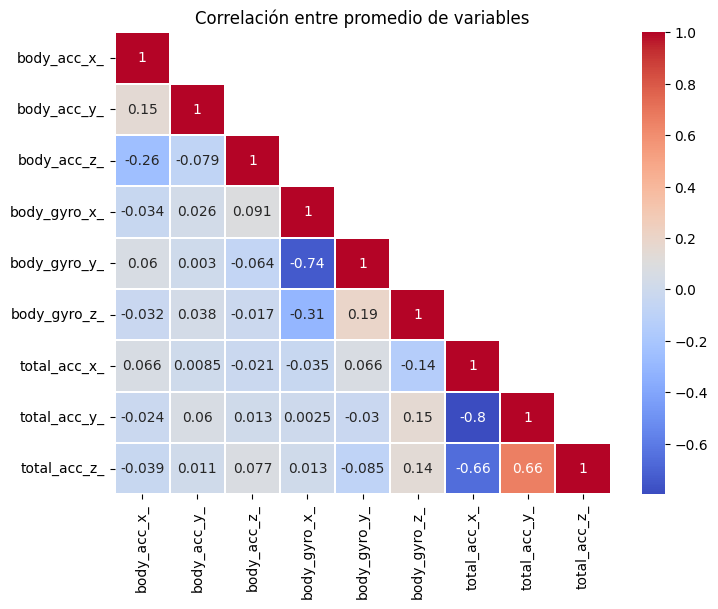

In [23]:
df_reduced = pd.DataFrame(x_train_reduced, columns=SIGNALS)

plt.figure(figsize = (8,6))

sns.heatmap(df_reduced.corr(), cmap='coolwarm', linewidths=0.1,
            annot=True, linecolor='white',
            mask = np.triu(np.ones_like(df_reduced.corr(), dtype=bool), k = 1)
            )

plt.title('Correlación entre promedio de variables');

De los gráficos anteriores podemos notar que todas las feuture tienen gran cantidad de outliers, además las feutures de "body_acc" y "body_giro" están centradas en el 0 y sus distribuciones con colas muy livianas. En "total_acc" se tiene que en el eje x la distribución está fuertemente cargada a valores cerca del 1, para el eje y se tiene que la distribución está fuertemente cargada en el intervalo [-0.4,0] y para el eje z se tiene que está centrada en el eje 0, pero con mucha más dispersión que en las otras feutures centradas en el 0.

Finalmente en "body_giro" hay alta correlación negativa entre el eje x e y, también sucede lo mismo en "total_acc", aunque en esta también hay una correlación positiva no despreciable entre el eje z y el eje y. Para el restos de correlaciones son bastante bajas o despreciables, en especial las correlaciones de una feuture con otra.


> d) Si quisiera entrenar una red neuronal feedforward con este conjunto de datos, ¿cómo deben representarse las dimensiones de cada experimento (sample) para que sirvan de entrada para este tipo de red?

Cada experimento debe estar representado como un vector unidimensional, para que cada entrada del vector represente una neurona en la capa de entrada de la red neuronal.

> e) Modifique las dimensiones de los atributos para luego entrenar una red neuronal feedforward.

In [24]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2]))

> f) ¿Cómo quedó cada atributo ahora que modificó sus dimensiones?

Quedaron unidimensionales, dejando como cada feature como una combinación entre el tipo de señal y algún índice de los valores de la señal (entre 1 y 128). Por ejemplo, una variable podría ser el total_acc_x en el primer instante, otra el body_gyro_y en el instante 120, etc.

### 2.1.3 Procesamiento del conjunto de datos

> a) Transforme las clases a One Hot Encoder

In [25]:
onehot_encoder = OneHotEncoder(sparse_output=False)

y_train_OHE = onehot_encoder.fit_transform(y_train.reshape(len(y_train), 1))
y_test_OHE = onehot_encoder.transform(y_test.reshape(len(y_test), 1))

# Print the original labels and the one-hot encoded labels
print("Original Labels:")
print(y_train.shape)
print("\nOne-Hot Encoded Labels:")
print(y_train_OHE.shape)

Original Labels:
(7352,)

One-Hot Encoded Labels:
(7352, 6)


> b) ¿Estan bien balanceadas las clases?


Grafiquemos la distribución de las clases en la variable target:

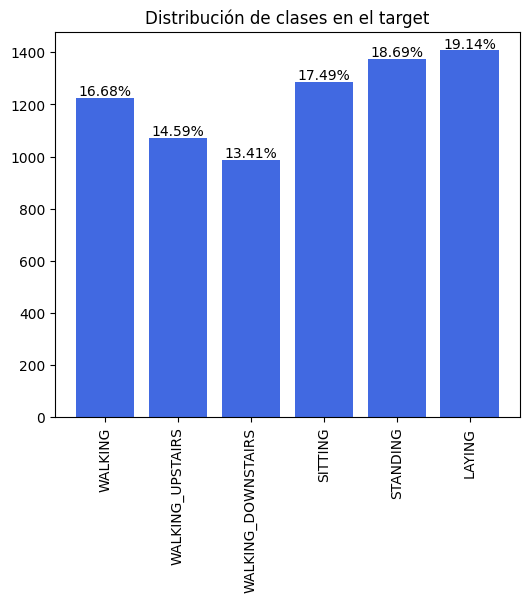

In [26]:
plt.figure(figsize = (6,5))
plt.bar(LABELS,
        np.unique(y_train, return_counts=True)[1],
        color = 'royalblue')
plt.title('Distribución de clases en el target')
plt.xticks(rotation=90)

for i, v in enumerate(np.unique(y_train, return_counts=True)[1]):
    plt.text(i, v+10, f'{v/len(y_train):.2%}', color='black', ha='center')

Las clases de caminar por las escaleras hacia arriba y abajo tienen menos apariciones en el data set, en cambio las clases de estar parado y acostado tienen más, sin embargo, igual podría ser razonable considerar los datos como balanceados ya que no se alejan tanto del promedio.

> c) Estandarice los atributos con media 0 y variaza 1.

In [27]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## 2.2 Modelos de clasificación

### 2.2.1 Redes Neuronales

> a) ¿Cómo se entrena una red neuronal feedforward?

Se inicializan los pesos y los bias y se usan para hacer la transformación lineal impuesta del modelo para luego evaluarlas en las funciones activación e ir avanzando de esta manera en las capas de la red hasta obtener los outputs, una vez obtenido los outputs se calcula la función de perdida y ocupamos backpropagation para ir actualizando los pesos y bias, lo que hace para actualizar es usar métodos de gradiente descendiente desde el output hacia los pesos y bias.

> b) ¿Qué es una neurona en este contexto?

Una neurona en el contexto de las redes neuronales es una unidad de procesamiento básica que realiza operaciones matemáticas en los datos de entrada para generar una salida utilizando pesos, un sesgo y una función de activación.

> c) ¿Qué es una función de activación y para que sirven?

Es una función aplicada a la salida de una neurona en una red neuronal, las más comunes son: lineal, sigmoid, ReLU, softmax, etc. Sirven para introducir no linealidad en la red y permiten modelar relaciones más complejas en los datos. Ayudan a determinar la salida de una neurona, facilitan el aprendizaje y la capacidad de generalización de la red neuronal.

> d) ¿A qué se le llama capa densa?

Es un tipo de capa en la que cada neurona está conectada a todas las neuronas de la capa anterior.

> e) Si usted conoce la dimensión entrada, la de salida, la cantidad de capas y neuronas de cada capa, ¿cómo se calcula la cantidad de pesos de la red?

La cantidad de pesos es igual a la cantidad de conexiones entre capas (agregando como nodo al _bias_), si consideramos que las capas son densas, la cantidad de conexiones entre dos capas es igual al producto de la cantidad de nodos de cada una, generalizando la idea tenemos que el total de pesos vienen dados por:

$$\# pesos = (N_e + 1)N_1 + \sum_{i  = 1}^{CO - 1} (N_i+1)N_{i+1} + (N_{CO}+1)N_s, \quad \text{si}~~ CO \geq 1$$
$$\# pesos = (N_e + 1)N_s,\quad \text{si}~~ CO = 0$$
Donde $N_i$ es la cantidad de neuronas de la $i$-ésima capa oculta, $N_e$ es la dimensión de entrada, $N_s$ la dimensión de salida y $CO$ la cantidad de capas ocultas. (Obs: Sumamos uno en el primer término de los productos, pues consideramos los _bias_)

> f) ¿A qué se refiere el fenómeno de gradiente desvaneciente?, ¿y el gradiente explosivo?

El fenómeno de gradiente desvaneciente es un problema que se tiene en las redes neuronales cuando se utiliza métodos tipo gradiente descendiente, en donde pasa que si la red neuronal tiene demasiadas capas, entonces el gradiente tiende a ser muy pequeño lo que impide que se actualice de buena manera los pesos y haga que el entrenamiento de la red se quede estancado.

El fenómeno de gradiente explosivo sucede cuando las funciones de activación pueden tomar valores muy grandes o se inicializa la red con pesos bastante grandes, eso implica que el gradiente este compuesto por factores bastante grandes, haciendo así que este "explote", ocasionando así problemas de convergencia y numéricos.

> g) Para esta tarea, como debería ser la capa de salida de la red considerando que previamente aplicó una transformación One Hot Encoding a las clases del conjunto?

Debería ser una capa de 6 neuronas, cada una con la probabilidad de pertenecer a la clase, como el modelo es multiclase lo recomendado es usar _softmax_ como función de activación en la capa de salida.

> h) Considere que la capa de entrada se llama "input_layer",  a la capa de salida le llamaremos "output_layer" y a las capas intermedias "hidden_layer(_units_, _activation_)" donde los parametros significan el numero de neuronas que tiene esa capa densa (Dense en Keras) y su activación. Cree las siguientes redes neuronales:

* input_layer -> output_layer

* input_layer -> hidden_layer(32, tanh) -> output_layer

* input_layer -> hidden_layer(32, sigmoid) -> output_layer

* input_layer -> hidden_layer(32, relu) -> output_layer

In [28]:
numero_de_entradas = x_train.shape[1]
numero_de_salidas = 6

modelos = [
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'Sin_capa_oculta'),
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=32, activation='tanh'),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'Modelo_tanh'),
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=32, activation='sigmoid'),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'Modelo_sigmoid'),
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=32, activation='relu'),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'Modelo_relu')
]

> i) Una vez creado el modelo, imprima el sumario (modelo.summary()) y compare los resultados obtenidos con su razonamiento explicado en la pregunta e).

In [29]:
for modelo in modelos:
  modelo.summary()
  print("\n")

Model: "Sin_capa_oculta"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 6918      
                                                                 
Total params: 6,918
Trainable params: 6,918
Non-trainable params: 0
_________________________________________________________________


Model: "Modelo_tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                36896     
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 37,094
Trainable params: 37,094
Non-trainable params: 0
_________________________________________________________________


Model: "Modelo_sigmo

Calculemos la cantidad de pesos según la fórmula entregada en e).

In [30]:
N_e = x_train.shape[1] #dimension entrada
N_s = 6 #dimension salida

def cant_pesos(N_e, N_s, CO=0, Nodos_capas_ocultas=[]):
  # Cantidad de pesos con capas ocultas densas
  if CO == 0:
    return (N_e+1)*N_s
  pesos_c = (N_e+1) * Nodos_capas_ocultas[0]
  for i in range(CO-1):
    pesos_c += (Nodos_capas_ocultas[i] + 1 ) * Nodos_capas_ocultas[i+1]
  pesos_c += (Nodos_capas_ocultas[-1] + 1) * N_s
  return pesos_c

pesos_sin = cant_pesos(N_e,N_s)
pesos_con = cant_pesos(N_e,N_s,1,[32])

print(f'Cantidad de pesos:\n\tModelo sin capa oculta: {pesos_sin:,}\n\tModelo con una capa oculta: {pesos_con:,}')

Cantidad de pesos:
	Modelo sin capa oculta: 6,918
	Modelo con una capa oculta: 37,094


Note que obtuvimos la misma cantidad de pesos.

 > j) Defina un callback de Early Stopping para evitar un sobre ajuste de la red basandose en sus respuestas a las siguientes preguntas:

* ¿Qué es lo que se debería monitorear para evitar el sobre ajuste en esta red?

**RESPUESTA:**

Para evitar el sobreajuste en esta red, se debería monitorear el rendimiento del modelo en un conjunto de datos de validación durante el entrenamiento. El objetivo es detectar cuándo el rendimiento en el conjunto de validación comienza a empeorar o deja de mejorar significativamente, lo que indica que el modelo está sobreajustando los datos de entrenamiento.

* ¿Qué es la paciencia en este contexto?

**RESPUESTA:**

La paciencia en este contexto se refiere al número de epochs que se permite que el rendimiento en el conjunto de validación empeore o se estanque antes de detener el entrenamiento. Si el rendimiento en el conjunto de validación no mejora después de un número determinado de epochs definido por la paciencia, se detiene el entrenamiento para evitar un sobreajuste adicional.

* ¿Para qué se usa el parámetro min_delta?

***RESPUESTA:***

El parámetro min_delta se usa para definir la mínima mejora requerida en el rendimiento en el conjunto de validación para considerar que hay una mejora significativa. Si la mejora en el rendimiento es menor que el valor de min_delta, no se considera una mejora real y puede detenerse el entrenamiento incluso si la paciencia no se ha agotado.

Dadas las respuestas previas, definiremos el Early Stopping que maximice (mode='max') la precisión categorica en el conjunto de validación (parámetro _monitor_) con una paciencia de 50 epochs, se fija el parámetro _verbose_=0 para que no printee resultados intermedios.

In [31]:
early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           mode='max',
                           verbose=0,
                           patience=50,
                           min_delta = 0.001
                           )

> k) Compile el modelo usando como optimizador el gradiente descendente estocástico, utilice la métrica "categorical_accuracy" y responda lo siguiente:

* ¿Que función de pérdida se debe usar para este problema (loss)?

**RESPUESTA:**

Para este problema, que implica la clasificación de múltiples clases, se debe utilizar la función de pérdida "categorical_crossentropy". Esta función de pérdida es comúnmente utilizada en problemas de clasificación multiclase y es adecuada para modelos que generan salidas en forma de distribuciones de probabilidad para cada clase.

In [32]:
# Compilamos los modelos
for modelo in modelos:
    modelo.compile(optimizer='sgd',
                   loss='categorical_crossentropy',
                   metrics=['categorical_accuracy']
                   )

> l) Entrene el modelo utilizando el callback definido en la pregunta anterior con 100 epochs, un batch_size=256, y validation split=0.1.

* ¿Qué significa el batch_size?

**RESPUESTA:**

Es la cantidad de muestras de entrenamiento que se utilizan en cada paso de actualización de los pesos del modelo.

In [33]:
for modelo in modelos:
  modelo.fit(x_train, y_train_OHE,
             epochs=100,
             batch_size=256,
             validation_split = 0.1,
             callbacks=[early_stop],
             verbose = 0
             )

> m) Escoja el mejor modelo según la función de activación y puntuación obtenida en el conjunto de validación y pruebe con los siguientes modelos:

* input_layer -> hidden_layer(64, best_activ) -> hidden_layer(32, best_activ) -> output_layer

* input_layer -> hidden_layer(128, best_activ) -> hidden_layer(64, best_activ) -> hidden_layer(32, best_activ) -> output_layer

* input_layer -> hidden_layer(256, best_activ) -> hidden_layer(128, best_activ) -> hidden_layer(64, best_activ) -> hidden_layer(32, best_activ) -> output_layer

Escojamos el mejor modelo según la métrica utilizada:

In [34]:
for modelo in modelos:
    loss, accuracy = modelo.evaluate(x_test, y_test_OHE, verbose = 0)
    print(f"Modelo = {modelo.name}, {accuracy=:.3f}\n")

Modelo = Sin_capa_oculta, accuracy=0.558

Modelo = Modelo_tanh, accuracy=0.814

Modelo = Modelo_sigmoid, accuracy=0.706

Modelo = Modelo_relu, accuracy=0.877



En base al resultado anterior, tenemos que la mejor función de activación es la 'ReLU'.

A continuación creamos las redes usando esta función de activación.

In [35]:
numero_de_entradas = x_train.shape[1]
numero_de_salidas = 6

NNs = [
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=64, activation='relu'),
                Dense(units=32, activation='relu'),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'NN_1'),
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=128, activation='relu'),
                Dense(units=64, activation='relu'),
                Dense(units=32, activation='relu'),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'NN_2'),
    Sequential([Input(shape = (numero_de_entradas)),
                Dense(units=256, activation='relu'),
                Dense(units=128, activation='relu'),
                Dense(units=64, activation='relu'),
                Dense(units=32, activation='relu'),
                Dense(units=numero_de_salidas, activation='softmax')],
               name = 'NN_3')
]

>n) Imprima las curvas de error y accuracy del conjunto de entrenamiento y de validación para observar como se comporta el _aprendizaje_ de sus modelos.

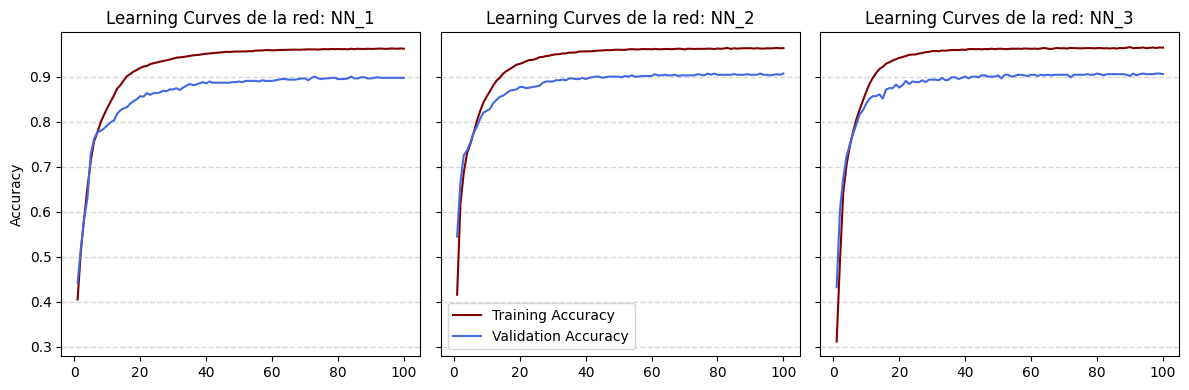

In [36]:
_, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, NN in enumerate(NNs):
  NN.compile(optimizer='sgd',
             loss='categorical_crossentropy',
             metrics = ['accuracy']
             )
  history = NN.fit(x_train, y_train_OHE,
                   epochs=100,
                   batch_size=256,
                   validation_split = 0.1,
                   verbose = 0
                   )
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(1, len(train_acc) + 1)

  axs[i].plot(epochs, train_acc, label='Training Accuracy', color = 'maroon')
  axs[i].plot(epochs, val_acc, label='Validation Accuracy', color = 'royalblue')

  axs[i].set_title(f'Learning Curves de la red: {NN.name}')
  axs[i].grid(axis = 'y', linewidth = 1, linestyle = '--', alpha = 0.5)


axs[0].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.show()

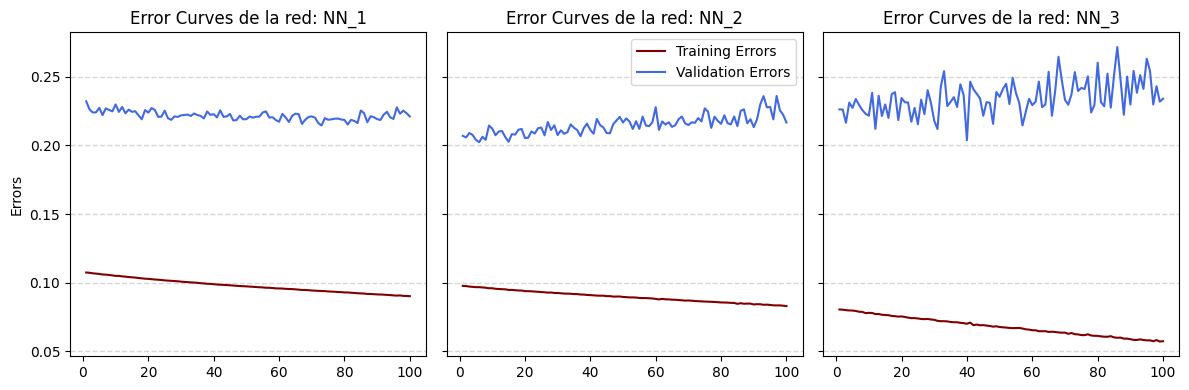

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, NN in enumerate(NNs):
  NN.compile(optimizer='sgd',
             loss='categorical_crossentropy',
             metrics = ['accuracy']
             )
  history = NN.fit(x_train, y_train_OHE,
                   epochs=100,
                   batch_size=256,
                   validation_split = 0.1,
                   verbose = 0
                   )
  train_errors = history.history['loss']
  val_errors = history.history['val_loss']
  epochs = range(1, len(train_errors) + 1)

  axs[i].plot(epochs, train_errors, label='Training Errors', color = 'maroon')
  axs[i].plot(epochs, val_errors, label='Validation Errors', color = 'royalblue')

  axs[i].set_title(f'Error Curves de la red: {NN.name}')
  axs[i].grid(axis = 'y', linewidth = 1, linestyle = '--', alpha = 0.5)


axs[0].set_ylabel('Errors')
axs[1].legend()
plt.tight_layout()
plt.show()

Podemos notar por simple inspección que el comportamiento de los training acurracy son bastante similar, pero para NN_1 se tiene un menor acurracy para el test de validación, para los otros modelos se tiene que las curvas acurracy en validación son razonablemente iguales módulo fluctuaciones.

Para los errores se tiene que el que tiene mejores resultados en los training errors es el modelo NN_3, pero para los de validación, el mejor es NN_2

> o) Una vez terminados los entrenamientos elija la mejor red hasta ahora y entrénela con el conjunto de entrenamiento completo sin validation split.

Queremos el modelo que se comporte de mejor manera en el set de validación, para que así pueda generalizar mejor, por lo dicho anteriormente el modelo NN_2 es el que tiene mejores resultados de acurracy y errores en el validation set, por lo que nos quedamos con este modelo.

In [ ]:
ANN = NNs[1] #NN_2
ANN.compile(optimizer='sgd',
            loss='categorical_crossentropy',
            metrics = ['accuracy']
            )
# POR DEFECTO SE TIENE 'validation_split=0.0'
ANN.fit(x_train, y_train_OHE,
        epochs=100,
        batch_size=256,
        verbose = 0
        );

> p) Procese las predicciones del modelo sobre el conjunto de test para que pueda comparar los errores usando un heatmap de la matriz de confusión.

In [ ]:
# Predecimos el conjunto de test
y_pred = ANN.predict(x_test, verbose = 0)

# Calculamos la mayor probabilidad de pertenecer a una clase:
y_pred = np.argmax(y_pred, axis=1)

# Hacemos comparable los valores:
y_test_comp = np.argmax(y_test_OHE, axis=1)

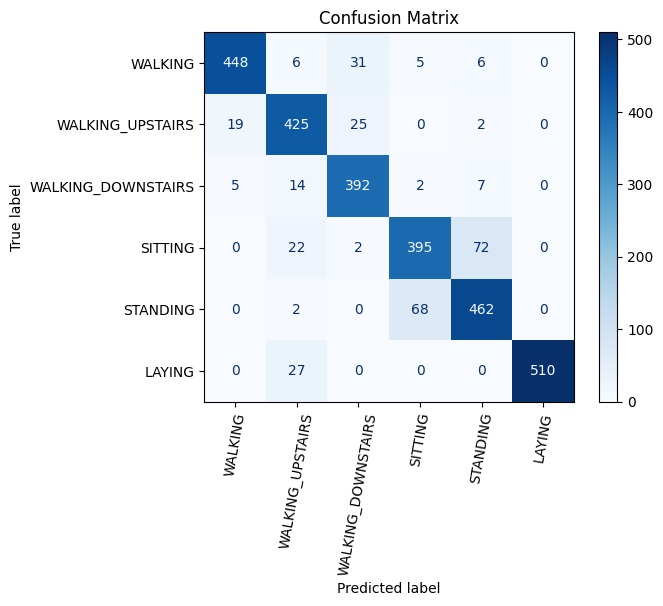

In [ ]:
# Creamos el heatmap de la matriz de confusion
ConfusionMatrixDisplay.from_predictions(
    y_test_comp,
    y_pred,
    cmap=plt.cm.Blues,
    display_labels=LABELS,
    xticks_rotation = 80
)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test_comp, y_pred, target_names = LABELS))

                    precision    recall  f1-score   support

           WALKING       0.95      0.90      0.93       496
  WALKING_UPSTAIRS       0.86      0.90      0.88       471
WALKING_DOWNSTAIRS       0.87      0.93      0.90       420
           SITTING       0.84      0.80      0.82       491
          STANDING       0.84      0.87      0.85       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.89      2947
         macro avg       0.89      0.89      0.89      2947
      weighted avg       0.90      0.89      0.89      2947



> q) Comente acerca de los resultados y explique cual es la actividad que mejor logra clasificar la red.

Podemos observar del heatmap de la matriz de confusión, que el modelo se comporta razonablemente bien, ya que la diagonal predomina en la matriz. Además, notamos que el modelo confunde un poco las actividades 'STANDING' y 'SITTING'.

Complementando los resultados visuales obtuvimos el clasification report, de donde tenemos que las métricas accuracy, recall y la precisión a nivel macro dan 88% de rendimiento, lo cual es un resultado razonable.

Al ver la matriz de confusión claramente la clase que mejor se clasifica es "LAYING", en donde cada observación que se predijo como "LAYING", efectivamente pertenecía a esa clase y solamente 27 observaciones de esta clase fueron mal clasificadas, lo que es un rendimiento bastante mejor en comparación con las otras.


### 2.2.2 AdaBoost y arbustos

> a) Describa brevemente como funciona el modelo AdaBoost.

El modelo AdaBoost es un clasificador de ensamblado boosting, es decir, que busca ensamblar varios modelos de clasificación de bajo rendimiento para crear un modelo de alto rendimiento. Este modelo en particular lo que hace es entrenar un modelo en el conjunto de entrenamiento y luego las observaciones mal predichas le otorga pesos para darle mayor importancia a la hora de entrenar denuevo y también se le otorga peso al modelo según su acertividad, prosiguiendo de manera los pasos anteriores de manera secuencial y combinando los modelos obtenidos.

> b) ¿Qué clasificador se puede usar junto con Adaboost?

Se puede usar cualquier clasificador mientras acepte que el training set este ponderado por pesos.

> c) ¿Cómo funciona el _learning rate_ en el modelo AdaBoost?

Es el peso que se le otorga a cada clasificador después de cada iteración del boosting, por lo que a mayor learning rate, habría una mayor contribución de cada clasificador.

> d) Separe el conjunto de entrenamiento dejando el 10% para validación.


In [ ]:
x_train_ada, x_val, y_train_ada, y_val = train_test_split(x_train, y_train,
                                                          test_size = 0.1,
                                                          shuffle=True,
                                                          random_state = 42)

> e) Entrene un clasificador AdaBoost con un arbusto (árbol de profundidad=2) con 300 estimadores y learning_rate=1


In [ ]:
ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2, random_state = 42),
    n_estimators = 300,
    learning_rate = 1,
    random_state = 42
)

ada.fit(x_train_ada, y_train_ada)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    random_state=42),
                   learning_rate=1, n_estimators=300, random_state=42)

> f) Revise el error de validación con el conjunto de validación.

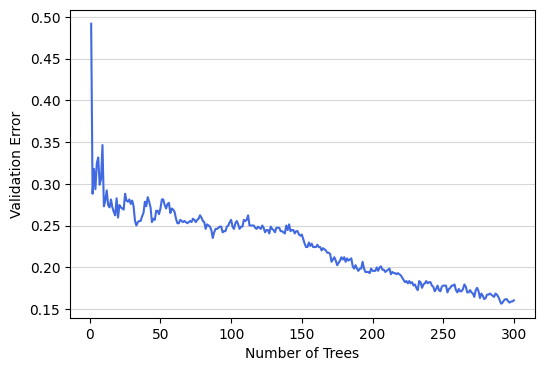

In [ ]:
val_predict = ada.predict(x_val)

ada_val_errors = []

for ada_val_predict in ada.staged_predict(x_val):
    ada_val_errors.append(1.0 - accuracy_score(ada_val_predict, y_val))

plt.figure(figsize=(6,4))

plt.plot(
    range(1, len(ada) + 1),
    ada_val_errors,
    c="royalblue"
)
plt.ylabel("Validation Error")
plt.xlabel("Number of Trees")
plt.grid(axis='y', alpha = 0.5)
plt.show()

In [ ]:
print(f'El mínimo error por etapa en el conj. de validación es: {np.min(ada_val_errors):.3f} que se da con {np.argmin(ada_val_errors)+1} árboles.')
print(f'Y el error en el conj. de validación completo es: {1-accuracy_score(val_predict, y_val):.3f}')

El mínimo error por etapa en el conj. de validación es: 0.156 que se da con 291 árboles.
Y el error en el conj. de validación completo es: 0.160


> g) Haga la misma prueba pero ahora con 30 estimadores

In [ ]:
ada_30 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2, random_state = 42),
    n_estimators = 30,
    learning_rate = 1,
    random_state = 42
)

ada_30.fit(x_train_ada, y_train_ada)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    random_state=42),
                   learning_rate=1, n_estimators=30, random_state=42)

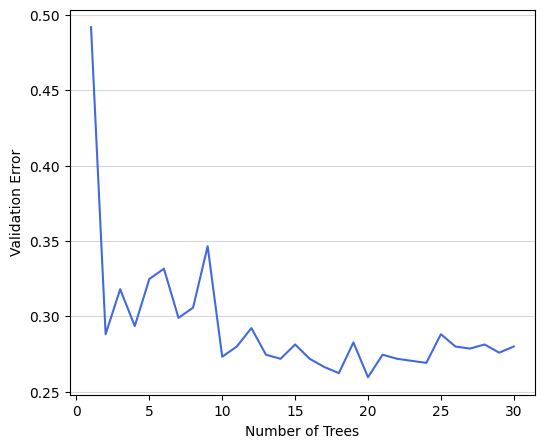

In [ ]:
ada_30_val_errors = []

for ada_val_predict in ada_30.staged_predict(x_val):
    ada_30_val_errors.append(1.0 - accuracy_score(ada_val_predict, y_val))

plt.figure(figsize=(6, 5))

plt.plot(
    range(1, len(ada_30) + 1),
    ada_30_val_errors,
    c="royalblue"
)
plt.grid(axis='y', alpha = 0.5)
plt.ylabel("Validation Error")
plt.xlabel("Number of Trees")
plt.show()

In [ ]:
print(f'El mínimo error por etapa en el conj. de validación es: {np.min(ada_30_val_errors):.3f} que se da con {np.argmin(ada_30_val_errors)+1} árboles.')
print(f'Y el error en el conj. de validación completo es: {1-accuracy_score(ada_30.predict(x_val), y_val):.3f}')

El mínimo error por etapa en el conj. de validación es: 0.260 que se da con 20 árboles.
Y el error en el conj. de validación completo es: 0.280


> h) Una vez encontrado el mejor modelo basandose en el error de validación, entrene el mejor modelo con todo el conjunto de entrenamiento, es decir, sin hacer _validation split_ y luego evalúe el modelo sobre el conjunto de pruebas.

Según el error en nuestro conjunto de validación, el modelo con 300 estimadores es mejor, por lo que usaremos este

In [ ]:
ada_final = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2, random_state = 42),
    n_estimators=300,
    learning_rate=1,
    random_state = 42
)

ada_final.fit(x_train, y_train)

y_pred = ada_final.predict(x_test)

> i) Muestre la matriz de confusión y comente sus resultados.

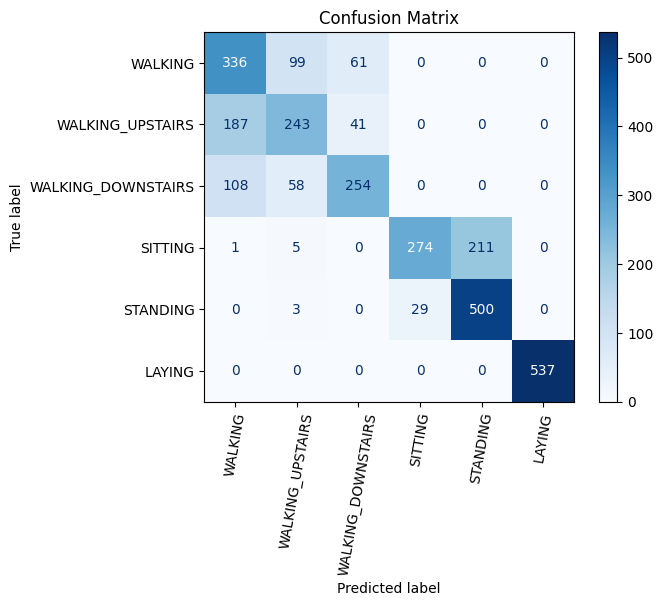

In [ ]:
# Creamos el heatmap de la matriz de confusion
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap=plt.cm.Blues,
    display_labels=LABELS,
    xticks_rotation = 80
)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names = LABELS))

                    precision    recall  f1-score   support

           WALKING       0.53      0.68      0.60       496
  WALKING_UPSTAIRS       0.60      0.52      0.55       471
WALKING_DOWNSTAIRS       0.71      0.60      0.65       420
           SITTING       0.90      0.56      0.69       491
          STANDING       0.70      0.94      0.80       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.73      2947
         macro avg       0.74      0.72      0.72      2947
      weighted avg       0.75      0.73      0.72      2947



Podemos ver que la clase "LAYING" fue predicha de manera perfecta por nuestro modelo. En cambio, para las otras clases hubo bastante más errores, nuestro modelo no logra distinguir por completo y confunde las actividades: 'WALKING', 'WALKING_UPSTAIRS' y 'WALKING_DOWNSTAIRS' entre ellas y también las actividades 'STANDING' y 'SITTING'.

Complementando la información observada en el heatmap de la matriz de confusión, el reporte de clasificación nos entrega que las métricas de rendimiento están por debajo del 75%, lo que no consideramos razonable para un modelo.

## 2.3 Conclusiones

> Comente con qué modelo obtiene los mejores resultados, ¿qué otros experimentos realizaría para intentar mejorar los resultados?


En un contexto en que fuese mejor predecir de manera correcta la clase "LAYING", el modelo de adaboost sería el mejor, ya que predice esa clase a la perfección según nuestro test set, pero de manera general, este modelo no obtuvo tan buenos resultados, de hecho su accuracy fue de un 73% aproximadamente. En cambio, el mejor modelo de redes neuronales obtuvo un accuracy del 88%, por lo que es mucho mejor modelo para predecir de manera general las clases, esto mismo se puede interpretar a simple vista con las matrices de confusión presentadas anteriormente, para el modelo de redes neuronales la diagonal es claramente predominante lo cual no sucede con el modelo AdaBoost.

Siguiendo la misma línea del enfoque de la pregunta, se pudo haber ocupado una técnica de ensamblaje de boosting en conjunto con modelos de redes neuronales.